#Contexto

La transferencia de estilo en imágenes es una aplicación de redes neuronales convolucionales (CNN) que permite modificar una imagen aplicando el estilo de otra. En esencia, se creó para democratizar el acceso a técnicas avanzadas de edición y generación de contenido visual, permitiendo que tanto profesionales como aficionados puedan experimentar y crear imágenes únicas sin requerir habilidades de diseño avanzadas. Su aplicación puede extenderse a mejorar la interactividad en aplicaciones de redes sociales, videojuegos y entornos de realidad aumentada.En un contexto más amplio, la transferencia de estilo facilita la creación de contenido visual atractivo sin la necesidad de herramientas avanzadas de edición manual, democratizando el acceso al diseño profesional. También ha sido utilizada en la preservación del arte, permitiendo aplicar estilos de pinturas clásicas a imágenes modernas y en el desarrollo de interfaces gráficas personalizadas.En este proyecto, utilizamos TensorFlow Hub para acceder a un modelo preentrenado de transferencia de estilo desarrollado por Google Magenta.

In [ ]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from PIL import Image as PILImage

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.18.0
TF-Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Justificación de Cambios o Adaptaciones**

Mejorar la interfaz: incluir una opción para descargar la imagen generada.

Cambio de imaganes: Se incluyo la salida del resultado de las imágenes

In [ ]:
# @title Define image loading and visualization functions  { display-mode: "form" }
# Función para recortar el centro de una imagen y obtener una imagen cuadrada.
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

# Función para cargar y preprocesar la imagen subida.
@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img
# Función para mostrar imágenes en la aplicación de Streamlit.

def show_n(images, titles=('',), save_images=False, save_path="images_output"):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320

    if save_images and not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)

    saved_files = []

    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')

        if save_images:
            img_path = os.path.join(save_path, f"image_{i}.png")
            img_array = (images[i][0].numpy() * 255).astype(np.uint8)  # Convertimos el tensor a NumPy
            PILImage.fromarray(img_array).save(img_path)
            saved_files.append(img_path)

    plt.show()

    if save_images:
        for file in saved_files:
            print(f"Descargar imagen: {file}")

189063/189063 ━━━━━━━━━━━━━━━━━━━━ 1s 3us/step
1034147/1034147 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


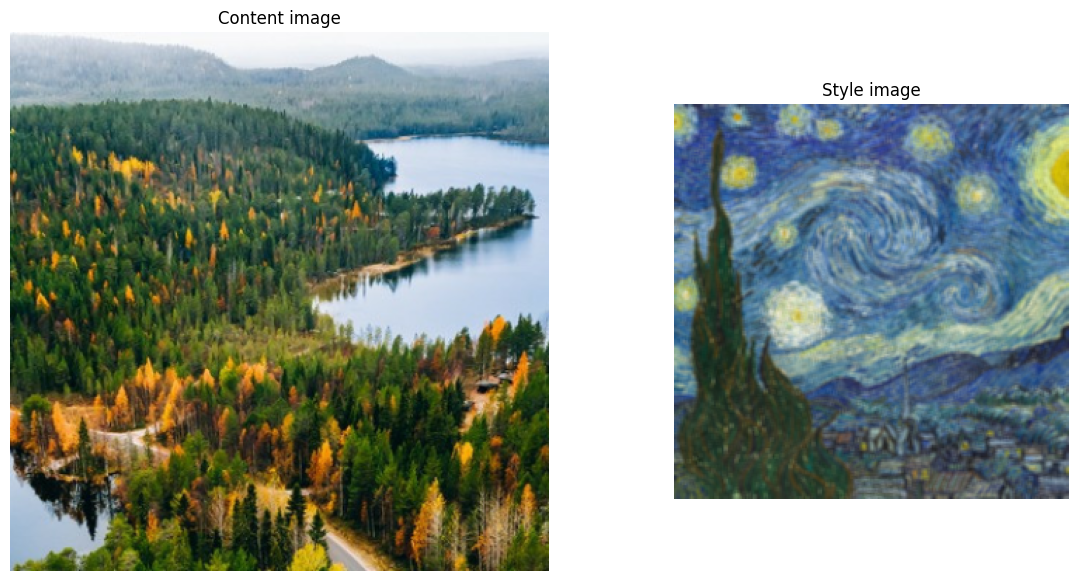

tf.Tensor(
[[[[0.3699144  0.51935333 0.6859497 ]
   [0.42581534 0.5663654  0.67973894]
   [0.4863875  0.6087971  0.6621184 ]
   ...
   [0.25800747 0.373699   0.5170692 ]
   [0.24162374 0.3445445  0.49736664]
   [0.23246287 0.32915163 0.48944342]]

  [[0.42984623 0.5655602  0.6609067 ]
   [0.46076024 0.5897384  0.6437062 ]
   [0.4869298  0.60381836 0.6078637 ]
   ...
   [0.2646732  0.388449   0.5279064 ]
   [0.2502489  0.36458254 0.5062573 ]
   [0.21606359 0.32561004 0.46732467]]

  [[0.48762614 0.61867875 0.6576557 ]
   [0.47796038 0.60131896 0.6153478 ]
   [0.47996917 0.588915   0.56124866]
   ...
   [0.30042997 0.45760432 0.60495293]
   [0.300492   0.43645716 0.57606494]
   [0.27910095 0.40276152 0.5320923 ]]

  ...

  [[0.28372458 0.34577942 0.27693334]
   [0.23837171 0.29779688 0.2954607 ]
   [0.22662666 0.28568295 0.30455953]
   ...
   [0.30910435 0.32445186 0.35773125]
   [0.31878152 0.3334089  0.3625475 ]
   [0.33611554 0.34964797 0.3814826 ]]

  [[0.2730801  0.33457965 0.282850

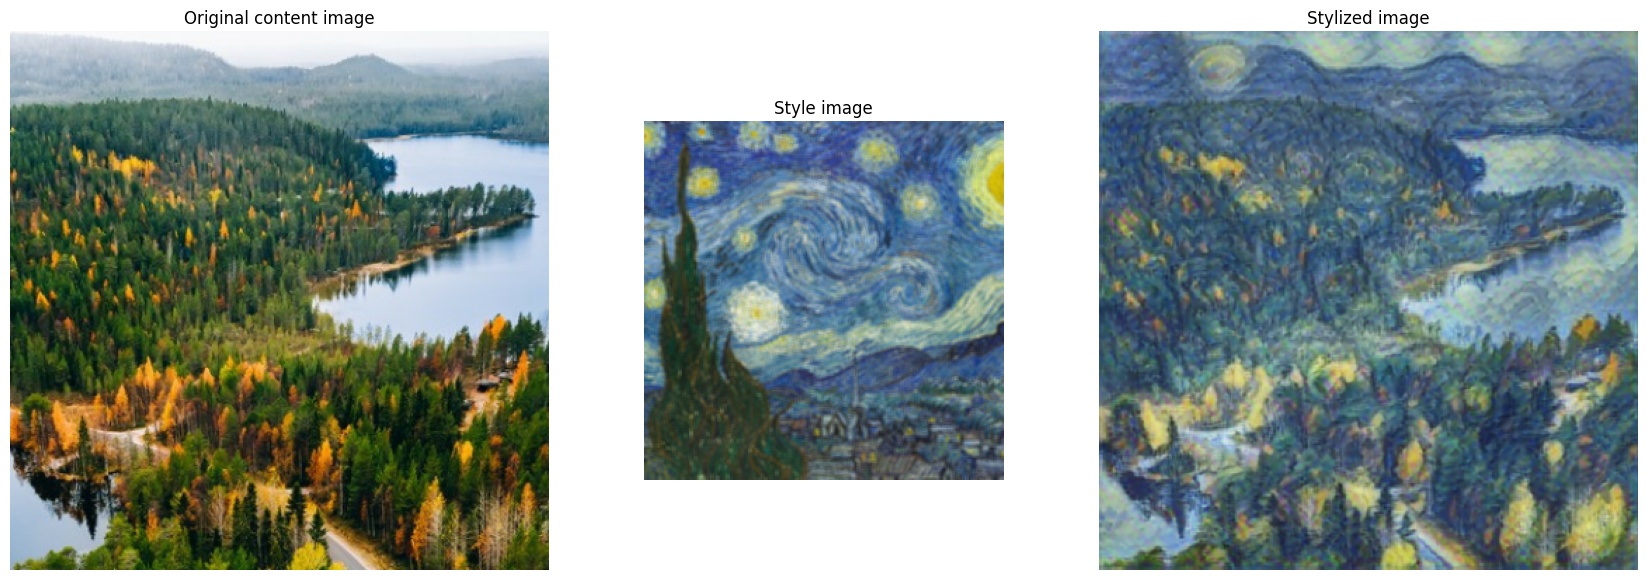

In [ ]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://www.interhome.es/upload/travelguide/7073/responsive-images/finlandia-los-lagos-mas-bonitos-hero___responsive_999_368.jpg'  # @param {type:"string"}
style_image_url = 'https://hips.hearstapps.com/hmg-prod/images/noche-estrellada-1646762819.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])
print(style_image)
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

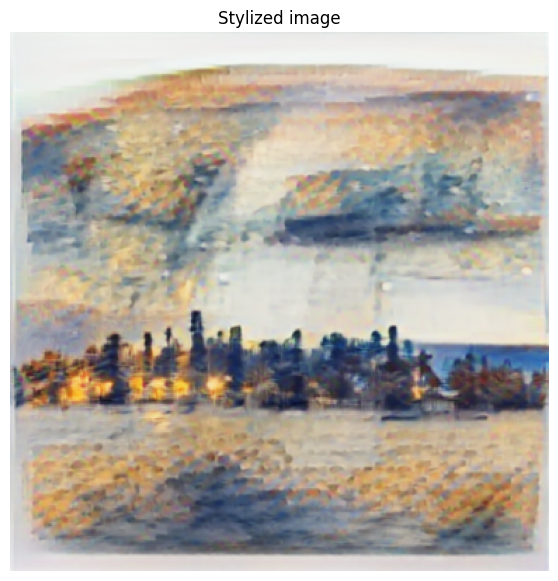

Descargar imagen: images_output/image_0.png


In [ ]:
show_n([stylized_image], titles=['Stylized image'], save_images=True)

406531/406531 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
397382/397382 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


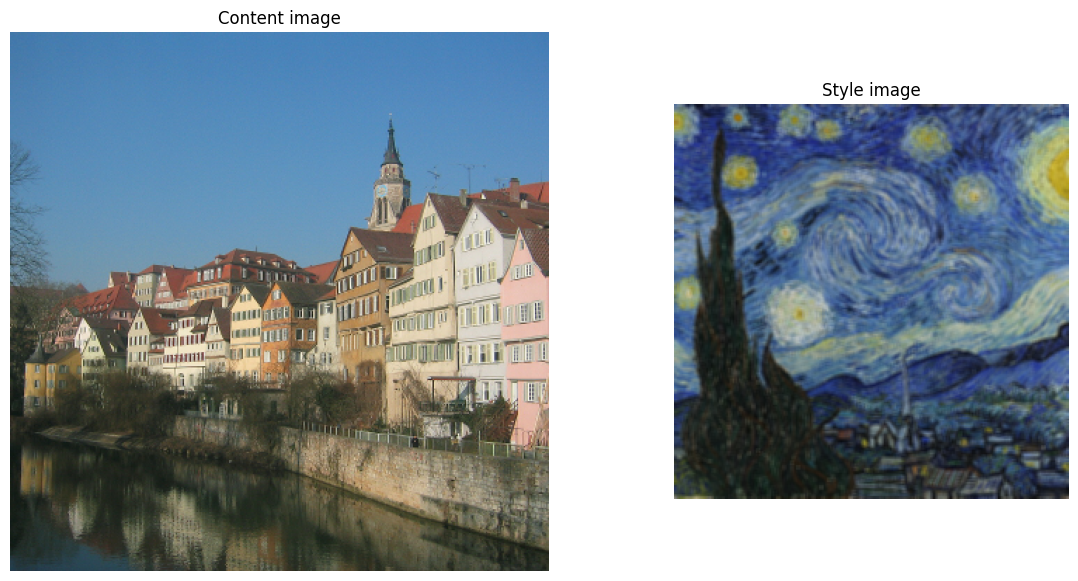

tf.Tensor(
[[[[0.32478994 0.4278757  0.5980084 ]
   [0.3605501  0.4643258  0.6127486 ]
   [0.4314955  0.5345719  0.6359675 ]
   ...
   [0.29441947 0.35767803 0.53704643]
   [0.3217907  0.40421867 0.55845845]
   [0.36593887 0.4570862  0.60975   ]]

  [[0.36858723 0.46965122 0.6004962 ]
   [0.39357084 0.49071524 0.608507  ]
   [0.42478144 0.52020985 0.60384166]
   ...
   [0.26256454 0.32922766 0.51738656]
   [0.29190472 0.37120438 0.53595334]
   [0.32582775 0.41105816 0.568396  ]]

  [[0.3744504  0.46337554 0.5792197 ]
   [0.37882406 0.47131094 0.5645316 ]
   [0.3804504  0.4794509  0.5320506 ]
   ...
   [0.2450916  0.3197662  0.51517993]
   [0.2251322  0.30717865 0.4947948 ]
   [0.25480378 0.34317335 0.52064466]]

  ...

  [[0.3449393  0.37815112 0.32883736]
   [0.28920746 0.33085886 0.29722002]
   [0.26441494 0.30481365 0.25625724]
   ...
   [0.19396515 0.19465803 0.18511856]
   [0.19476709 0.19692561 0.18510588]
   [0.19664064 0.19698235 0.18323499]]

  [[0.44471824 0.45301008 0.396251

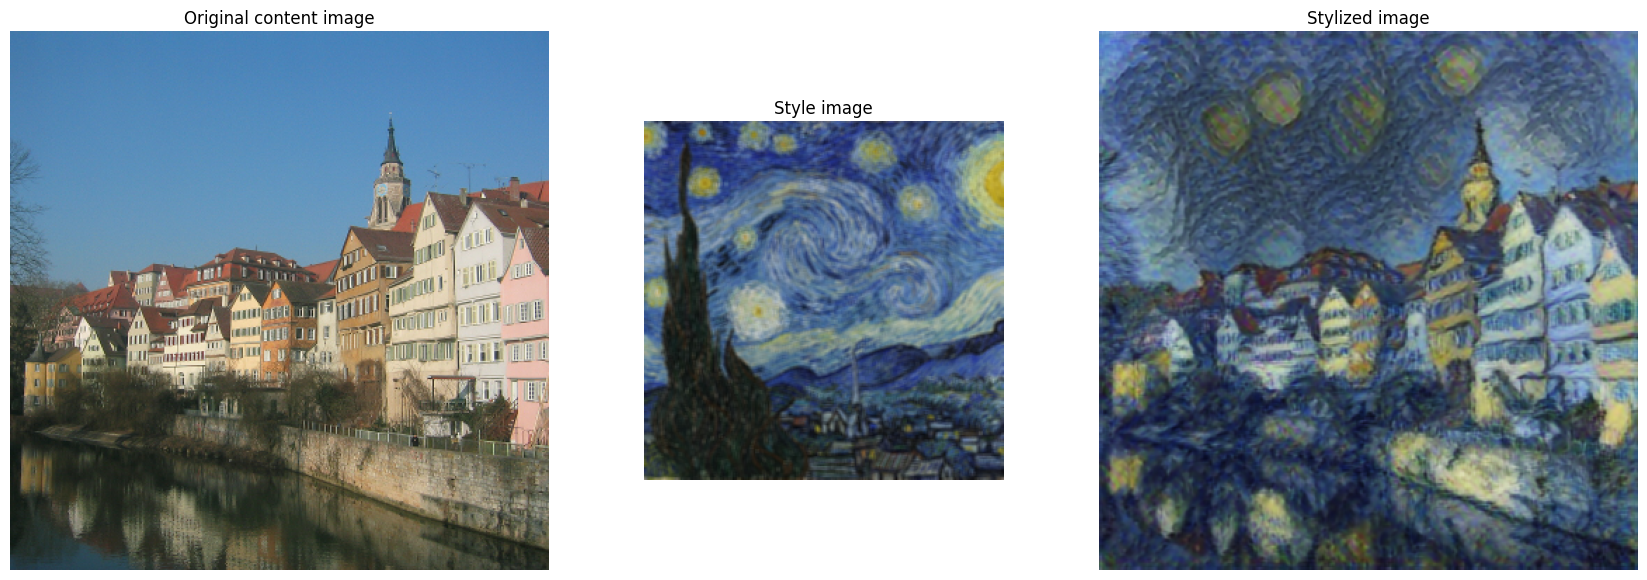

In [ ]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])
print(style_image)
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

473320/473320 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
239488/239488 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


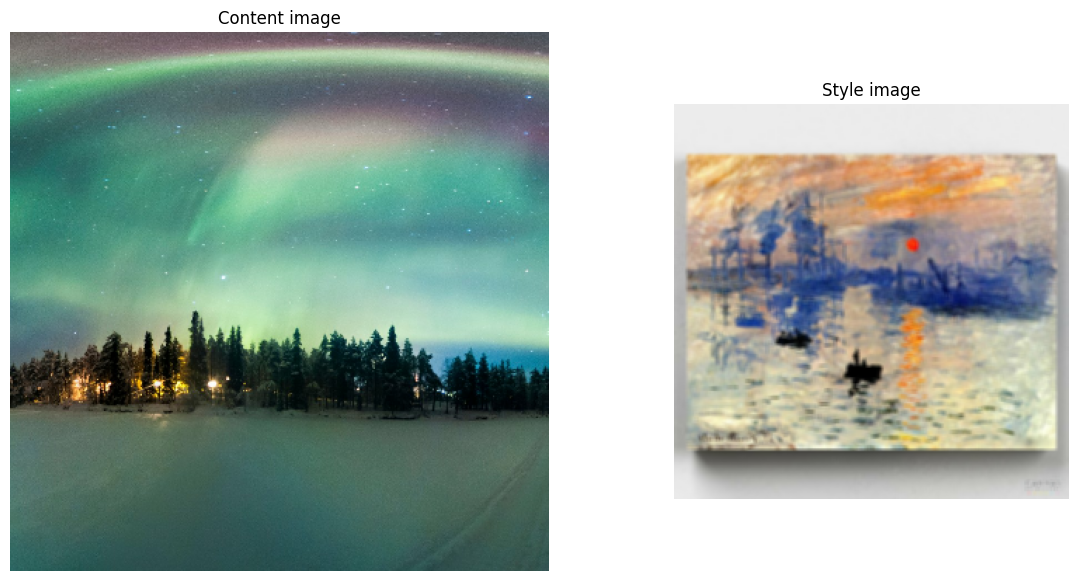

tf.Tensor(
[[[[0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]
   ...
   [0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]]

  [[0.92810464 0.92810464 0.92810464]
   [0.92723316 0.92723316 0.92723316]
   [0.92636174 0.92636174 0.92636174]
   ...
   [0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]]

  [[0.9307191  0.9307191  0.9307191 ]
   [0.92897606 0.92897606 0.92897606]
   [0.92723316 0.92723316 0.92723316]
   ...
   [0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]
   [0.92549026 0.92549026 0.92549026]]

  ...

  [[0.91846913 0.91846913 0.91846913]
   [0.91819507 0.91819507 0.91819507]
   [0.91841394 0.91841394 0.91841394]
   ...
   [0.8505449  0.8505449  0.8505449 ]
   [0.8508044  0.8508044  0.8508044 ]
   [0.8493606  0.8493606  0.8493606 ]]

  [[0.9176446  0.9176446  0.917644

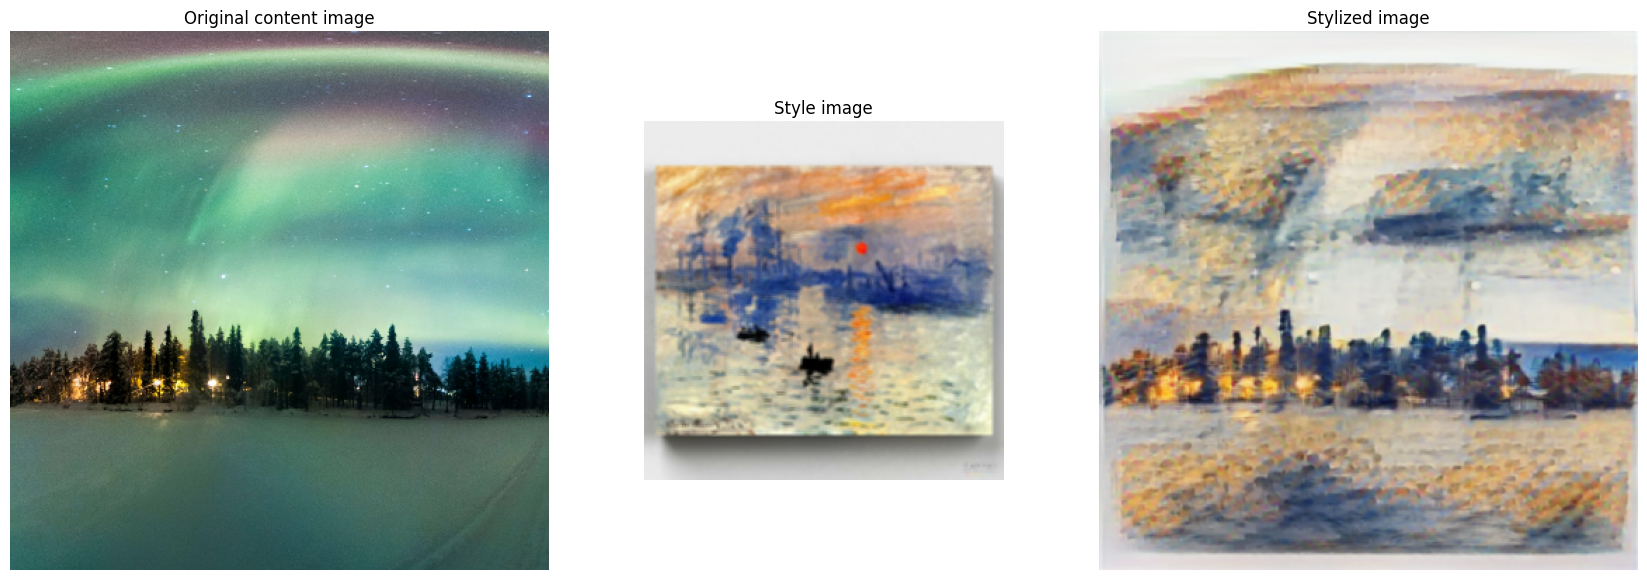

In [ ]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://dynamic-media-cdn.tripadvisor.com/media/photo-o/15/33/f9/60/finland.jpg'  # @param {type:"string"}
style_image_url = 'https://canvasbynumbers.es/cdn/shop/articles/sol-naciente-pintura-impresionista-claude-monet.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])
print(style_image)
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

#Conclusiones

**Impacto en el sector de TI:**

* La transferencia de estilo con CNN es un ejemplo de cómo las redes neuronales
pueden generar contenido de manera autónoma, permitiendo automatizar procesos en la industria creativa y el diseño gráfico.

* La integración con Streamlit y TensorFlow demuestra el potencial de las arquitecturas de IA en la creación de herramientas interactivas, facilitando su acceso a usuarios sin conocimientos avanzados en aprendizaje profundo.

* La escalabilidad y disponibilidad en la nube de TensorFlow Hub permiten que este tipo de modelos sean accesibles a empresas y desarrolladores sin necesidad de infraestructura costosa, fomentando la adopción de IA en diversas industrias.

* La optimización computacional con el uso de GPUs y TPUs mejora la eficiencia en el procesamiento de imágenes, reduciendo tiempos de respuesta en aplicaciones en tiempo real.

* Estas tecnologías impulsan la creación de plataformas personalizadas en sectores como la moda, la animación y la producción de contenido digital.

**Impacto social y cultural:**

* Facilita la preservación y reinterpretación del arte, permitiendo aplicar estilos históricos a imágenes modernas sin alterar las obras originales.

* Democratiza el acceso a herramientas de diseño avanzado, permitiendo que artistas y creadores sin formación técnica utilicen redes neuronales para mejorar sus proyectos visuales.

* Su implementación en aplicaciones de redes sociales y videojuegos mejora la personalización de experiencias de usuario, permitiendo a los usuarios generar contenido único de manera sencilla.

* Puede utilizarse en programas educativos para enseñar principios de IA y redes neuronales de una manera visual e interactiva, fomentando el interés en tecnologías emergentes.

* En el ámbito de la accesibilidad, la transferencia de estilo podría ser utilizada en herramientas para personas con discapacidad visual parcial, mejorando la percepción de imágenes a través de la manipulación del color y la textura.

#Referencias

**Style Transfer**
https://github.com/ap539813/Image-style-transfer/blob/main/app_style_transfer.py

**Style Transfer**
https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization?hl=es-419

**Style Transfer**
https://github.com/gordicaleksa/pytorch-naive-video-neural-style-transfer/blob/master/naive_video_pipeline.py

**Style Transfer en videos**
https://www.youtube.com/watch?v=S78LQebx6jo&list=PLBoQnSflObcmbfshq9oNs41vODgXG-608&index=2

**Style Transfer**
https://www.youtube.com/watch?v=v7Dkmk-PNYk&list=PLYqjzjOgx6EF9FC7_H5BGaxx5W267exsn

Google Magenta: https://magenta.tensorflow.org

ChatGPT y ClaudeAI
